## Purpose: create a training set of sources with labels



In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from wisps import datasets

In [3]:
spex=datasets['spex']
#trash
trash=pd.read_pickle(wisps.OUTPUT_FILES+'/trash.pkl')
trash['label']=0.

In [4]:
man=(datasets['manjavacas']).rename(columns={'f':'f_test'})
schn=(datasets['schneider']).rename(columns={'f':'f_test'})

In [5]:
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl')

In [6]:
simulated_spectra=pd.DataFrame.from_records(pd.DataFrame(sf).values.flatten()).rename(columns={'f':'f_test', 'Names':'name'})

In [7]:
spex['spt']=spex.spt.apply(wisps.make_spt_number)
man['spt']=man.spt.apply(wisps.make_spt_number)
schn['spt']=schn.spt.apply(wisps.make_spt_number)
trash['spt']=trash.spt.apply(wisps.make_spt_number)

In [8]:
len(trash)

5798

In [9]:
spex['name']=spex['grism_id']

In [10]:
features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont', 'spt', 'spex_chi', 'name', 'snr2','snr1', 'snr3', 'snr4' ,
          'line_chi', 'f_test',  'label']

In [11]:
from scipy import stats

In [12]:
def f_test_comp(x):
    return stats.f.cdf(x, 2, 1, 0, scale=1)

man['x']=man.spex_chi/man.line_chi
schn['x']=schn.spex_chi/schn.line_chi
simulated_spectra['x']=simulated_spectra.spex_chi/simulated_spectra.line_chi
man['f_test']=man.x.apply(f_test_comp)
schn['f_test']=schn.x.apply(f_test_comp)
simulated_spectra['f_test']=simulated_spectra.x.apply(f_test_comp)
spex['f_test']=(spex.spex_chi/spex.line_chi).apply(f_test_comp)

In [13]:
simulated_spectra['spt']=simulated_spectra.spt_new.apply(wisps.make_spt_number)

In [14]:
simulated_spectra['name']=['spect {}'.format(idx) for idx in np.arange(len(simulated_spectra))] 

In [15]:
def add_labels(spt):
    label=0.0
    if spt>=17.:
        label=1.0
    return label

In [16]:

spex['label']=spex.spt.apply(add_labels)
man['label']=man.spt.apply(add_labels)
schn['label']=schn.spt.apply(add_labels)
simulated_spectra['label']=simulated_spectra.spt.apply(add_labels)
trash['label']=0.

In [17]:
#en(trash), len(simulated_spectra)

In [18]:
trash['name']=trash.grism_id

In [19]:
feats=[x for x in features if x not in ['name']]

In [20]:
training_set=wisps.Annotator.reformat_table(pd.concat( [trash[features], spex[features],
                                                        schn[features]]))

In [21]:
training_set=(training_set[feats]).dropna(how='all').reset_index(drop=True)

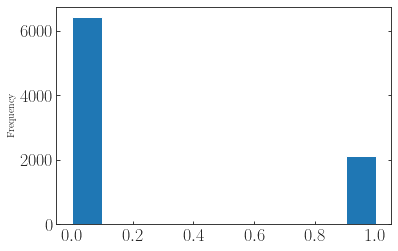

In [22]:
training_set.label.plot(kind='hist')

In [23]:
label0=(training_set[training_set.label==0]).reset_index(drop=True)
label1=(training_set[training_set.label==1]).reset_index(drop=True)

In [24]:
final_set=pd.concat([label0, label1]).reset_index(drop=True)

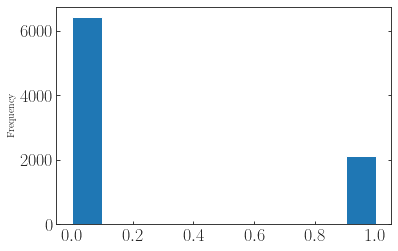

In [25]:
final_set.label.plot(kind='hist')

In [26]:
len(trash[trash.snr1>3.]), len(spex[spex.snr1>3]), len(schn[schn.snr1>3.]), len(label0), len(label1)

(4477, 2677, 19, 6415, 2103)

In [27]:
final_set[feats]=final_set[feats].applymap(float)
final_set.to_pickle(wisps.LIBRARIES+'/training_set.pkl')

In [28]:
len(final_set)

8518